<a href="https://colab.research.google.com/github/olavvn/NLP_Final/blob/main/doppelganger_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch datasets accelerate -U
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install pandas tqdm
!pip install sentencepiece
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 899.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 32.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/dialogue-song.csv')

In [ ]:
import pandas as pd

new_df = pd.DataFrame(columns=['User', 'Message'])
current_user = None
current_message = ""

for index, row in df.iterrows():
    if current_user is None:
        current_user = row['User']
        current_message += row['Message']
    elif current_user != row['User']:
        # Use pd.concat instead of append
        new_df = pd.concat([new_df, pd.DataFrame({'User': [current_user], 'Message': [current_message]})], ignore_index=True)
        current_user = row['User']
        current_message = row['Message']
    else:
        current_message += "\n" + row['Message']

if current_user is not None:
    # Use pd.concat instead of append
    new_df = pd.concat([new_df, pd.DataFrame({'User': [current_user], 'Message': [current_message]})], ignore_index=True)

me = new_df[new_df.User =='송수혁'].reset_index().Message
you = new_df[new_df.User =='김도훈'].reset_index().Message

data = pd.DataFrame({'me':me , 'you' : you})

In [ ]:
import torch
from transformers import PreTrainedTokenizerFast

checkpoint = 'skt/kogpt2-base-v2'
device = 'cuda'

tokenizer = PreTrainedTokenizerFast.from_pretrained(checkpoint,
  bos_token='<s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
from datasets import Dataset
dataset = Dataset.from_pandas(data).map(
    lambda x: {'text': f"### Me: {x['me']}\n### You: {x['you']}</s>" } #end token </s>
).train_test_split(test_size=0.1)

dataset = dataset.map(lambda x: tokenizer(x["text"] , truncation=True, max_length=128, padding="max_length"), batched=True)

Map:   0%|          | 0/2194 [00:00<?, ? examples/s]

Map:   0%|          | 0/1974 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

In [ ]:
dataset.shape

{'train': (1974, 6), 'test': (220, 6)}

In [ ]:
dataset['test'][0]

{'me': '머 타고 갈겨',
 'you': '버스\nㅇㅇ먹고있음',
 'text': '### Me: 머 타고 갈겨\n### You: 버스\nㅇㅇ먹고있음</s>',
 'input_ids': [739,
  378,
  378,
  378,
  36337,
  401,
  9763,
  12814,
  9546,
  6874,
  375,
  378,
  378,
  378,
  15369,
  15949,
  401,
  30152,
  375,
  601,
  601,
  7513,
  6889,
  8155,
  8139,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [ ]:
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained(checkpoint).to(device)

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

In [ ]:
from pytorch_lightning import Trainer

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,0.715000,0.768587
2,0.645600,0.755856
4,0.640300,0.753855


{'loss': 0.7095, 'grad_norm': 2.1083948612213135, 'learning_rate': 4.918699186991871e-06, 'epoch': 0.08097165991902834}
{'loss': 0.7813, 'grad_norm': 1.9114665985107422, 'learning_rate': 4.83739837398374e-06, 'epoch': 0.16194331983805668}
{'loss': 0.7217, 'grad_norm': 2.345344066619873, 'learning_rate': 4.75609756097561e-06, 'epoch': 0.242914979757085}
{'loss': 0.7147, 'grad_norm': 2.136303186416626, 'learning_rate': 4.67479674796748e-06, 'epoch': 0.32388663967611336}
{'loss': 0.6861, 'grad_norm': 1.81914484500885, 'learning_rate': 4.59349593495935e-06, 'epoch': 0.4048582995951417}
{'loss': 0.7741, 'grad_norm': 1.9517197608947754, 'learning_rate': 4.51219512195122e-06, 'epoch': 0.48582995951417}
{'loss': 0.734, 'grad_norm': 2.2050607204437256, 'learning_rate': 4.43089430894309e-06, 'epoch': 0.5668016194331984}
{'loss': 0.7159, 'grad_norm': 1.9816404581069946, 'learning_rate': 4.34959349593496e-06, 'epoch': 0.6477732793522267}
{'loss': 0.6749, 'grad_norm': 2.1107609272003174, 'learning_

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 50, 'do_sample': True}


{'loss': 0.63, 'grad_norm': 1.728685736656189, 'learning_rate': 9.349593495934959e-07, 'epoch': 4.048582995951417}
{'loss': 0.6343, 'grad_norm': 2.06628155708313, 'learning_rate': 8.53658536585366e-07, 'epoch': 4.129554655870446}
{'loss': 0.6187, 'grad_norm': 1.9525988101959229, 'learning_rate': 7.723577235772359e-07, 'epoch': 4.2105263157894735}
{'loss': 0.6525, 'grad_norm': 2.099864959716797, 'learning_rate': 6.910569105691058e-07, 'epoch': 4.291497975708502}
{'loss': 0.6744, 'grad_norm': 2.172731876373291, 'learning_rate': 6.097560975609757e-07, 'epoch': 4.372469635627531}
{'loss': 0.6087, 'grad_norm': 2.192453145980835, 'learning_rate': 5.284552845528456e-07, 'epoch': 4.4534412955465585}
{'loss': 0.6106, 'grad_norm': 2.1247801780700684, 'learning_rate': 4.471544715447155e-07, 'epoch': 4.534412955465587}
{'loss': 0.6017, 'grad_norm': 1.7601741552352905, 'learning_rate': 3.6585365853658536e-07, 'epoch': 4.615384615384615}
{'loss': 0.6316, 'grad_norm': 2.8103885650634766, 'learning_ra

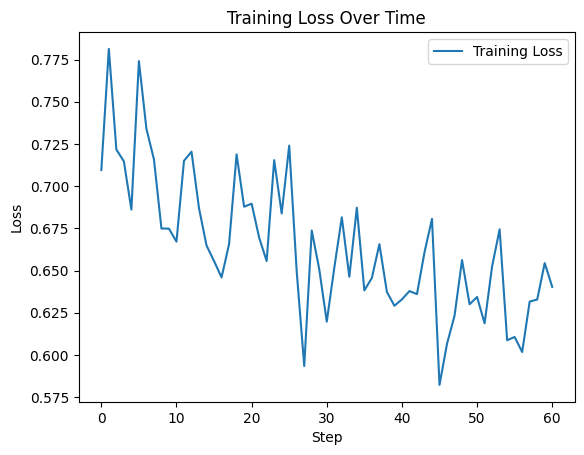

In [ ]:
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling, TrainerCallback, EarlyStoppingCallback
import numpy as np

tokenizer.pad_token = tokenizer.eos_token

def create_training_arguments(args_dict):
    args = TrainingArguments(
        output_dir=args_dict["output_dir"],
        evaluation_strategy=args_dict["evaluation_strategy"],
        per_device_train_batch_size=args_dict["per_device_train_batch_size"],
        gradient_accumulation_steps=args_dict["gradient_accumulation_steps"],
        num_train_epochs=args_dict["num_train_epochs"],
        save_total_limit=args_dict["save_total_limit"],
        logging_dir=args_dict["logging_dir"],
        logging_steps=args_dict["logging_steps"],
        weight_decay=0.01,
        learning_rate=5e-6,
    )
    return args

args_dict = {
    "output_dir": "test_trainer",
    "evaluation_strategy": "epoch",
    "per_device_train_batch_size": 4,
    "gradient_accumulation_steps": 4,
    "num_train_epochs": 5,
    "save_total_limit": 1,
    "logging_dir": "logs",
    "logging_steps": 10
}
training_args = create_training_arguments(args_dict)

class LogCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero:
            if "loss" in logs:
                self.losses.append(logs["loss"])
            print(logs)

    def plot_loss(self):
        plt.plot(np.arange(len(self.losses)), self.losses, label="Training Loss")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.title("Training Loss Over Time")
        plt.legend()
        plt.show()

log_callback = LogCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    callbacks=[log_callback]
)
trainer.train()

log_callback.plot_loss()


In [ ]:
trainer.model.save_pretrained('/content/drive/My Drive/chatbot1')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 50, 'do_sample': True}


In [ ]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0)


In [ ]:
your_prompt = "### You:안녕하세요 \n### Me:" # caution: Do not add blank space at the end of the prompt
your_max_length = len(your_prompt)+12
your_num_sequences = 1

generator(your_prompt, max_length=your_max_length, num_return_sequences=your_num_sequences)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'generated_text': '### You:안녕하세요 \n### Me: 뭐하고 계셈이냐면\n### You: ᄋ'}]

In [ ]:
model_path = '/content/drive/My Drive/chatbot1'


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from transformers import PreTrainedTokenizerFast
from transformers import pipeline, set_seed

checkpoint = 'skt/kogpt2-base-v2'
device = 'cuda'

tokenizer = PreTrainedTokenizerFast.from_pretrained(checkpoint,
  bos_token='<s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

model = AutoModelForCausalLM.from_pretrained(model_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
your_prompt = "### You:전역 8일 남음\n### Me:" # caution: Do not add blank space at the end of the prompt
your_max_length = len(your_prompt)+12
your_num_sequences = 1

generator(your_prompt, max_length=your_max_length, num_return_sequences=your_num_sequences)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'generated_text': '### You:전역 8일 남음\n### Me: 하루\n귀국하면 어어\n내가 휴가 가서 해줄수 있나\n#'}]